In [70]:
import kagglehub

# Download latest version
import os

dataset_dir = f"/Users/{os.getlogin()}/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1"
print(f"Dataset directory: {dataset_dir} -> checking if it exists")
if not os.path.exists(dataset_dir):
    print(f"Dataset directory: {dataset_dir} -> does not exist, downloading dataset")
    dataset_download_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
else:
    dataset_download_path = dataset_dir

print("Path to dataset files:", dataset_download_path)

Dataset directory: /Users/devendershekhawat/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1 -> checking if it exists
Path to dataset files: /Users/devendershekhawat/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [71]:
from pathlib import Path

model_dir_path = Path("./models")
Path.mkdir(model_dir_path, exist_ok=True)

In [72]:
model_v0_exists = os.path.exists(model_dir_path / "model_0.pth")
model_v1_exists = os.path.exists(model_dir_path / "model_v1.pth")

In [73]:
import torch
from torch import nn

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random

In [74]:
# Set device for MPS (Apple Silicon GPU) or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [75]:
from pathlib import Path

image_folder = Path(dataset_download_path) / "images"

train_path = image_folder / "train"
test_path = image_folder / "validation"


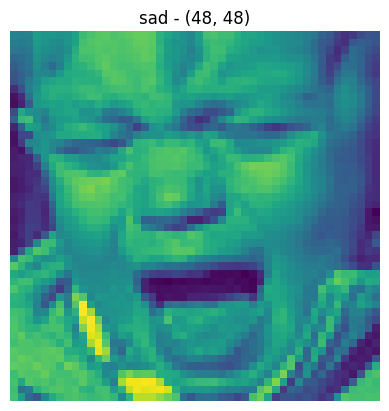

In [76]:
from PIL import Image

image_list = list(train_path.glob("*/*.jpg"))

random_image = random.choice(image_list)

image = Image.open(random_image)

plt.imshow(image)
plt.title(f"{random_image.parent.stem} - {image.size}")
plt.axis("off")
plt.show()

In [77]:
train_transform = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_path, transform=train_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)

In [78]:
train_dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [79]:
test_dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

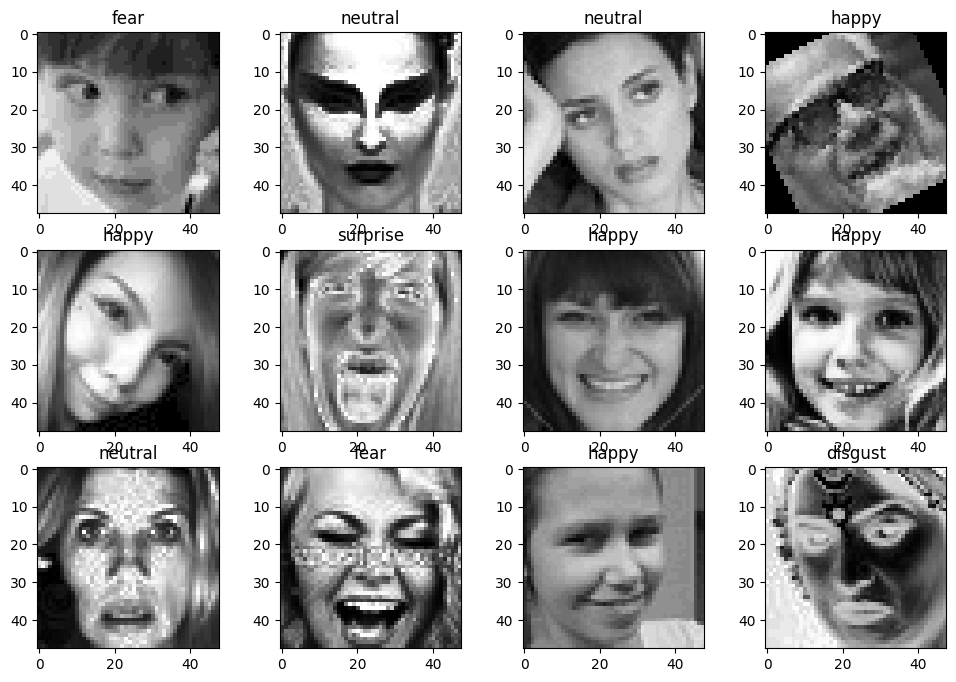

In [80]:
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_dataset_loader))

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(train_dataset.classes[labels[i]])

In [81]:
class FaceExpressionModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.fc_layer(x)
        return x


In [82]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [83]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [84]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [85]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [86]:
import torch
import numpy as np

# 1. Get the counts of each class from your training dataset
# (This might take a second if your dataset is large)
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

print(f"Counts: {class_counts}")

# 2. Calculate weights: Total_Samples / (Num_Classes * Class_Count)
total_samples = sum(class_counts)
num_classes = len(class_counts)

class_weights = []
for count in class_counts:
    weight = total_samples / (num_classes * count)
    class_weights.append(weight)

# Convert to Tensor and move to device (MPS)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights_tensor = torch.sqrt(class_weights_tensor)

print(f"Calculated Weights: {class_weights_tensor}")

# 3. Use THESE weights in your loss function
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

Counts: [3993, 436, 4103, 7164, 4982, 4938, 3205]
Calculated Weights: tensor([1.0154, 3.0730, 1.0017, 0.7581, 0.9091, 0.9131, 1.1334],
       device='mps:0')


In [87]:
model_0 = FaceExpressionModel(num_classes=len(train_dataset.classes))
model_0 = model_0.to(device)  # Move model to device (MPS or CPU)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [88]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

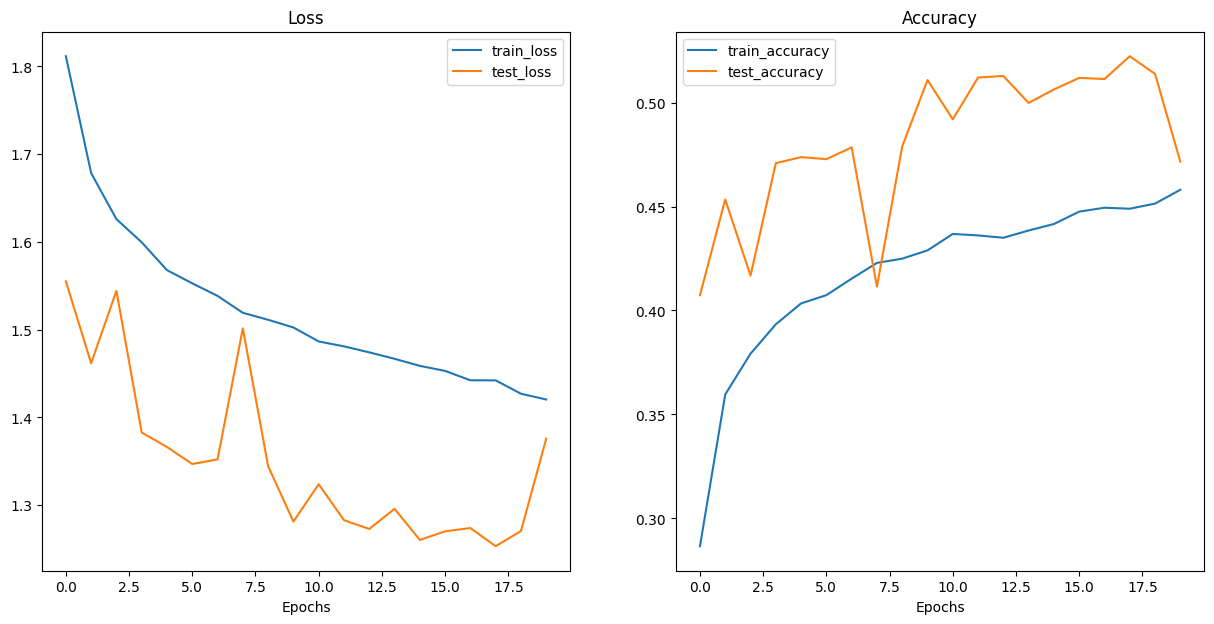

In [90]:
import json

if not model_v0_exists:
    model_results = train(
        model=model_0,
        train_dataloader=train_dataset_loader,
        test_dataloader=test_dataset_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=20
    )

    # Save model_results to a json file
    with open(model_dir_path / "model_0_results.json", "w") as f:
        json.dump(model_results, f)
else:
    model_0 = torch.load(model_dir_path / "model_0.pth", weights_only=False)
    with open(model_dir_path / "model_0_results.json", "r") as f:
        model_results = json.load(f)

plot_loss_curves(model_results)

Using device: mps


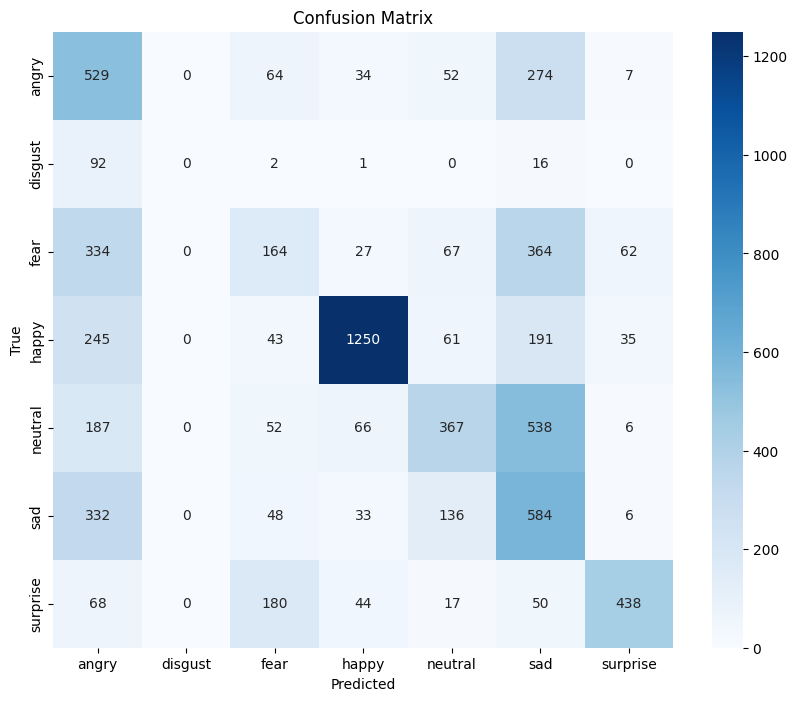

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names):
    # 0. Setup Device Agnostic Code
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Move model to MPS
    model.to(device)
    model.eval()

    y_preds = []
    y_trues = []
    
    with torch.inference_mode():
        for X, y in dataloader:
            # 1. Send data to MPS
            X, y = X.to(device), y.to(device)
            
            # 2. Forward pass (on MPS)
            logits = model(X)
            pred_labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            
            # 3. CRITICAL STEP: Move back to CPU before Numpy
            y_preds.extend(pred_labels.cpu().numpy())  # <--- Added .cpu()
            y_trues.extend(y.cpu().numpy())            # <--- Added .cpu()
            
    # 4. Create confusion matrix
    cm = confusion_matrix(y_trues, y_preds)
    
    # 5. Plot nicely
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run it
plot_confusion_matrix(model_0, test_dataset_loader, train_dataset.classes)

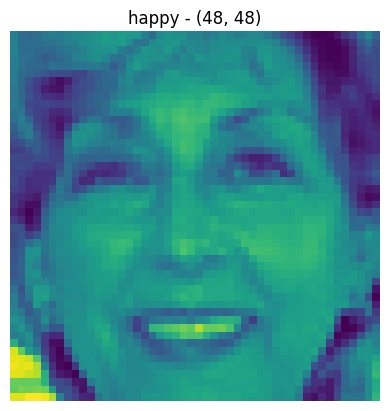

In [ ]:
#. Make a prediction
random_image = random.choice(image_list)
image = Image.open(random_image)
plt.imshow(image)
plt.title(f"{random_image.parent.stem} - {image.size}")
plt.axis("off")
plt.show()


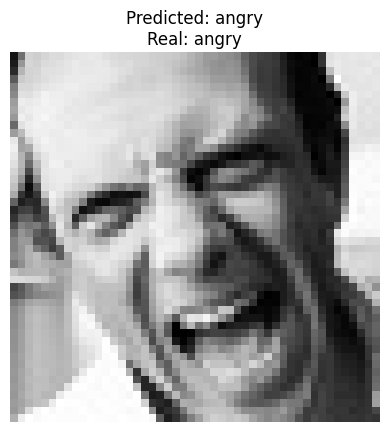

In [ ]:
import random

# Pick a random image from the test dataset
test_img_idx = random.randint(0, len(test_dataset) - 1)
img, real_label = test_dataset[test_img_idx]

# Prepare the image for the model
model_input = img.unsqueeze(0).to(device)

# Get the prediction
model_0.eval()
with torch.inference_mode():
    logits = model_0(model_input)
    predicted_label_idx = torch.argmax(torch.softmax(logits, dim=1), dim=1).item()

# Show image and prediction info
plt.figure()
plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray' if img.shape[0] == 1 else None)
plt.axis('off')
plt.title(f"Predicted: {train_dataset.classes[predicted_label_idx]}\nReal: {train_dataset.classes[real_label]}")
plt.show()


In [ ]:
torch.save(model_0, model_dir_path / "model_0.pth")

In [ ]:
from torchvision import models

def create_transfer_model(num_classes):
    # Load pre-trained brain
    model = models.resnet18(weights='DEFAULT')

    # Replace the output head
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(256, num_classes)
    )
    return model

# Note: Use a smaller Learning Rate (0.0001) for Transfer Learning

In [ ]:
model_v1 = create_transfer_model(num_classes=len(train_dataset.classes)).to(device)

In [ ]:
import random


def test_model_with_random_image(dataset,model):
        # Pick a random image from the test dataset
    test_img_idx = random.randint(0, len(dataset) - 1)
    img, real_label = dataset[test_img_idx]

    # Prepare the image for the model
    model_input = img.unsqueeze(0).to(device)

    # Get the prediction
    model.eval()
    with torch.inference_mode():
        logits = model(model_input)
        predicted_label_idx = torch.argmax(torch.softmax(logits, dim=1), dim=1).item()

    # Show image and prediction info
    plt.figure()
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray' if img.shape[0] == 1 else None)
    plt.axis('off')
    plt.title(f"Predicted: {train_dataset.classes[predicted_label_idx]}\nReal: {train_dataset.classes[real_label]}")
    plt.show()


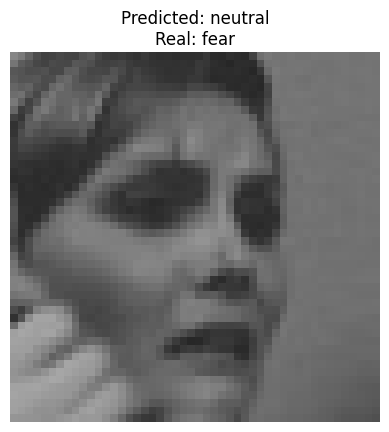

In [ ]:
test_model_with_random_image(test_dataset,model_v1)

Using device: mps


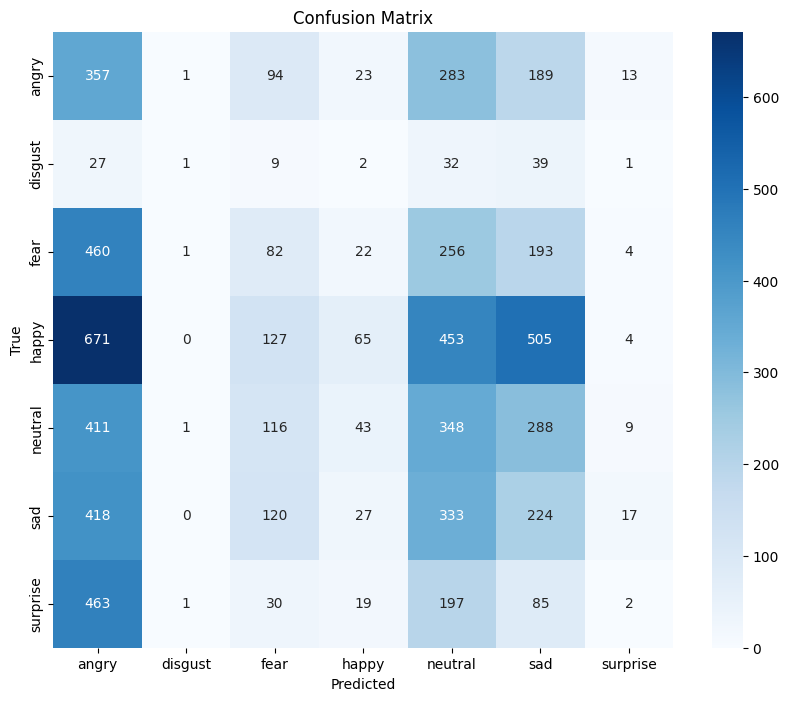

In [ ]:
plot_confusion_matrix(model_v1, test_dataset_loader, train_dataset.classes)

In [ ]:
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.0001)

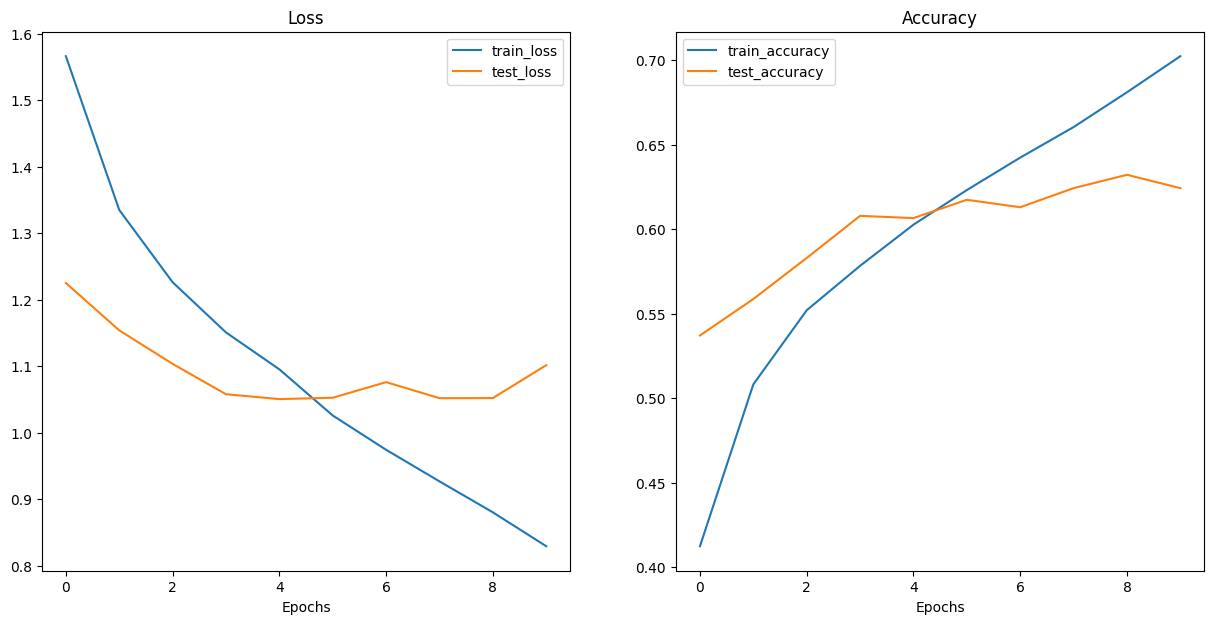

In [91]:
import json

if not model_v1_exists:
    # 2. Train it!
    # It will learn MUCH faster than your custom model.
    transfer_results = train(
        model=model_v1,        # The ResNet model
        train_dataloader=train_dataset_loader,
        test_dataloader=test_dataset_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,             # Reuse your weighted loss function
        epochs=10                    # 10 epochs is plenty for a start
    )

    # Save model_results to a json file
    with open(model_dir_path / "model_v1_results.json", "w") as f:
        json.dump(transfer_results, f)
else:
    model_v1 = torch.load(model_dir_path / "model_v1.pth", weights_only=False)
    with open(model_dir_path / "model_v1_results.json", "r") as f:
        transfer_results = json.load(f)

# 3. Plot the new curves
plot_loss_curves(transfer_results)

Using device: mps


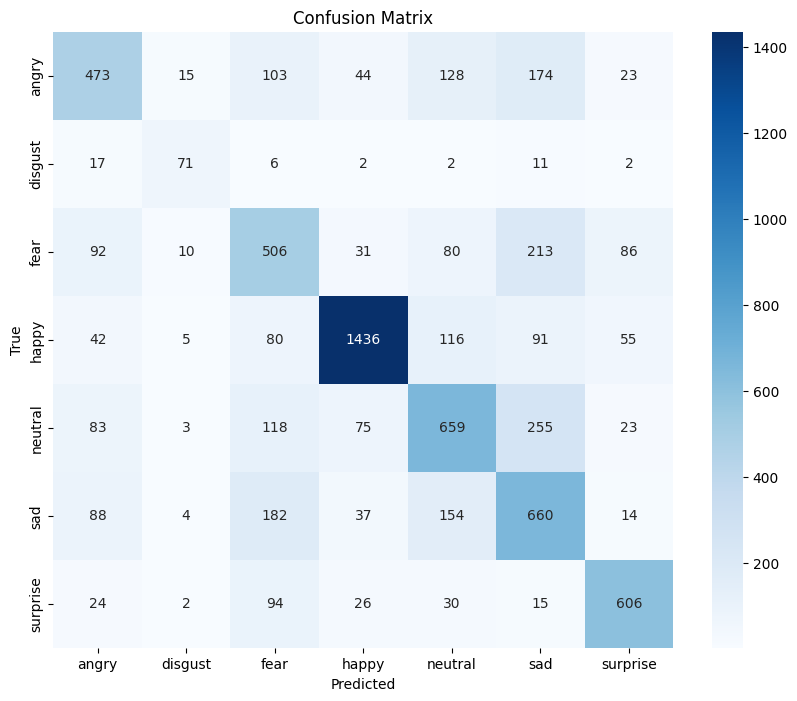

In [119]:
plot_confusion_matrix(model_v1, test_dataset_loader, train_dataset.classes)

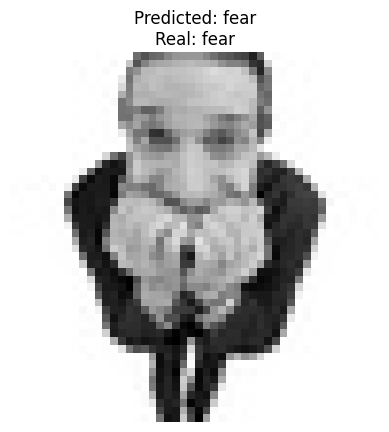

In [118]:
test_model_with_random_image(test_dataset,model_v1)

In [93]:
model_dir_path = Path("./models")
Path.mkdir(model_dir_path, exist_ok=True)
torch.save(model_v1, model_dir_path / "model_v1.pth")